# 1. Hyperparameter optimization

To install Optuna: run `pip install optuna` in console after activating your environment.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
import optuna
import optuna.visualization as vis  

seed = 42
torch.manual_seed(seed)

Load MNIST data. **DO NOT CHANGE THIS.**

In [47]:
def get_mnist_loaders(batch_size, valid_ratio, seed, downsample_ratio):
    # Define the transformation: convert to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Load the full training set (train=True returns the 60k training images)
    train_dataset = torchvision.datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=transform
    )
    
    # Optionally downsample the training data
    if downsample_ratio < 1.0:
        subset_size = int(len(train_dataset) * downsample_ratio)
        indices = list(range(subset_size))
        train_dataset = Subset(train_dataset, indices)
    
    # Load the test set (train=False returns the 10k testing images)
    test_dataset = torchvision.datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=transform
    )
    
    # Split training set into training and validation set
    train_size = int((1.0 - valid_ratio) * len(train_dataset))
    valid_size = len(train_dataset) - train_size
    gen = torch.Generator().manual_seed(seed)
    train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size], generator=gen)
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
    
    return train_loader, valid_loader, test_loader

batch_size = 128
valid_ratio = 0.2
downsample_ratio = 0.5

# Create the DataLoaders
train_loader, valid_loader, test_loader = get_mnist_loaders(batch_size=batch_size, 
                                                              valid_ratio=valid_ratio, 
                                                              seed=seed,
                                                              downsample_ratio=downsample_ratio)

# Total number of images in each dataset
print("Total training images:", len(train_loader.dataset))
print("Total validation images:", len(valid_loader.dataset))
print("Total test images:", len(test_loader.dataset))

Total training images: 24000
Total validation images: 6000
Total test images: 10000


## (1a) Implement CNN

Write here the network structure as described in the exercise sheet.

Remember to **make the kernel size a parameter**, so that it can be controlled later.

In [8]:
class CNN(nn.Module):
    def __init__(self, kernel_size):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=32), # infer the input shape
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=10),
            nn.LogSoftmax()
        )
            
    def forward(self, x):
        #x = x.view(x.size(0), -1)
        return self.layers(x)

device = "cuda" if torch.cuda.is_available() else "cpu"


#### (1b & 1c) Train&Test Functions

To help focus on tuning optimizers and networks, we provided 3 pre-written functions for training and testing.

By having clear functions, we can easily compare different settings and keep the process consistent.

**You do not need to change anything in this part.**

In [49]:
# Training function.
def train(net, train_loader, parameters, epochs=1):
    optimizer = torch.optim.SGD(net.parameters(), lr=parameters["lr"], momentum=parameters["momentum"])
    criterion = nn.NLLLoss()
    net.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return net

# Evaluation function.
def evaluate(net, data_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            predictions = outputs.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return accuracy

# Function for final training using best params on combined train and validation sets, then testing.
def train_test(parameters):
    combined_dataset = ConcatDataset([train_loader.dataset, valid_loader.dataset])
    combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
    
    net = CNN(kernel_size=parameters["kernel_size"]).to(device)
    net = train(net, combined_loader, parameters)
    test_accuracy = evaluate(net, test_loader)
    return test_accuracy

## (1b) Bayesian optimization using Optuna

Optuna requires an objective for the optimization.

Our objective returns validation accuracy, and we use **direction="maximize".**

So, we aim to maximize the accuracy of the validation dataset.

**Here, your task is to define the hyperparameter search spaces** (suggested hyperparameters).

Here you can see the documentary page for search spaces:

https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html

In [51]:
def objective(trial, device=device):
    # Define hyperparameter search spaces.
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    momentum = trial.suggest_float("momentum", 0.0, 1.0)
    kernel_size = trial.suggest_categorical("kernel_size", [3, 5, 7])
    parameters = {"lr": lr, "momentum": momentum, "kernel_size": kernel_size}
    
    # Initialize the model with the chosen kernel_size.
    net = CNN(kernel_size=kernel_size).to(device)
    
    # Train the model on the training set.
    net = train(net, train_loader, parameters)
    
    # Evaluate validation sets.
    val_accuracy = evaluate(net, valid_loader)
    
    # Return the validation accuracy (this is what we want to maximize).
    return val_accuracy

# Create Optuna study and optimize.
n_trials = 75
sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(sampler=sampler, direction="maximize")
study.optimize(objective, n_trials=n_trials)

print("Best hyperparameters:", study.best_trial.params)
print("Best validation accuracy:", study.best_trial.value)

[I 2025-04-03 20:43:24,355] A new study created in memory with name: no-name-65ad2872-f4f6-41a4-8e1e-d2649cc90b13
[I 2025-04-03 20:43:32,149] Trial 0 finished with value: 0.30783333333333335 and parameters: {'lr': 3.1489116479568635e-05, 'momentum': 0.9507143064099162, 'kernel_size': 3}. Best is trial 0 with value: 0.30783333333333335.
[I 2025-04-03 20:43:39,814] Trial 1 finished with value: 0.10633333333333334 and parameters: {'lr': 4.207053950287936e-06, 'momentum': 0.05808361216819946, 'kernel_size': 3}. Best is trial 0 with value: 0.30783333333333335.
[I 2025-04-03 20:43:47,491] Trial 2 finished with value: 0.1295 and parameters: {'lr': 1.2087541473056965e-06, 'momentum': 0.9699098521619943, 'kernel_size': 3}. Best is trial 0 with value: 0.30783333333333335.
[I 2025-04-03 20:43:55,263] Trial 3 finished with value: 0.06316666666666666 and parameters: {'lr': 5.415244119402541e-06, 'momentum': 0.3042422429595377, 'kernel_size': 3}. Best is trial 0 with value: 0.30783333333333335.
[I 2

Best hyperparameters: {'lr': 0.009225749809973626, 'momentum': 0.9738151097595154, 'kernel_size': 7}
Best validation accuracy: 0.9565


C:\Users\Matias\AppData\Local\Temp\ipykernel_20196\2604171193.py:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig_history = optuna.visualization.matplotlib.plot_optimization_history(study)


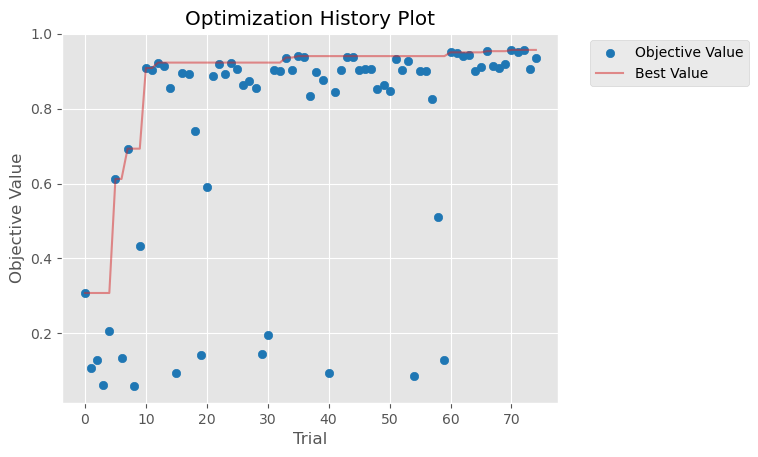

In [52]:
# Visualize the optimization history. (Interactive)
#fig_history = vis.plot_optimization_history(study)
#fig_history.show()

# Alternative Visualization. You can use this if the plot is not visible in .pdf version (Matplotlib plot)
fig_history = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

In [55]:
# Evaluate on the test set using the best hyperparameters.
test_accuracy = train_test(study.best_trial.params)
print("Test accuracy with best hyperparameters:", test_accuracy)

Test accuracy with best hyperparameters: 0.9659


## (1c) Grid search

Implement grid search for the same three parameters.

Remember that you **need to cover 75 alternatives in total.**

So, think about how to best allocate those to cover the three hyperparameters.

In [73]:
lr = np.geomspace(1e-6, 1e-2, 5)
momentum = np.arange(0.1, 1.0, 0.2)
kernel_size = np.array([3, 5, 7])

parameters = {"lr": lr, "momentum": momentum, "kernel_size": kernel_size}

best_acc = 0.0
best_acc_history = {"trial": [], "acc": []}
best_params = {}
val_accs = []
n_trial = 1

for l in lr:
    for m in momentum:
        for k in kernel_size:
            net = CNN(kernel_size=k).to(device)
            parameters = {"lr": l, "momentum": m, "kernel_size": k}
            net = train(net, train_loader, parameters)
            val_accuracy = evaluate(net, valid_loader)
            
            if val_accuracy > best_acc:
                best_acc = val_accuracy
                best_acc_history["trial"].append(n_trial)
                best_acc_history["acc"].append(best_acc)
                best_params = parameters
            
            val_accs.append(val_accuracy)

            print(f"Trial {n_trial} finished")
            print(f"Parameters : {parameters}")
            print(f"Validation accuracy: {val_accuracy}")
            print()
            n_trial += 1

print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_acc}")

c:\Users\Matias\miniconda3\Lib\site-packages\torch\nn\modules\module.py:1739: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Trial 1 finished
Parameters : {'lr': np.float64(1e-06), 'momentum': np.float64(0.1), 'kernel_size': np.int64(3)}
Validation accuracy: 0.06383333333333334

Trial 2 finished
Parameters : {'lr': np.float64(1e-06), 'momentum': np.float64(0.1), 'kernel_size': np.int64(5)}
Validation accuracy: 0.0745

Trial 3 finished
Parameters : {'lr': np.float64(1e-06), 'momentum': np.float64(0.1), 'kernel_size': np.int64(7)}
Validation accuracy: 0.09366666666666666

Trial 4 finished
Parameters : {'lr': np.float64(1e-06), 'momentum': np.float64(0.30000000000000004), 'kernel_size': np.int64(3)}
Validation accuracy: 0.09266666666666666

Trial 5 finished
Parameters : {'lr': np.float64(1e-06), 'momentum': np.float64(0.30000000000000004), 'kernel_size': np.int64(5)}
Validation accuracy: 0.14316666666666666

Trial 6 finished
Parameters : {'lr': np.float64(1e-06), 'momentum': np.float64(0.30000000000000004), 'kernel_size': np.int64(7)}
Validation accuracy: 0.09216666666666666

Trial 7 finished
Parameters : {'lr'

In [74]:
test_accuracy = train_test(best_params)
print("Test accuracy with best hyperparameters:", test_accuracy)

Test accuracy with best hyperparameters: 0.9545


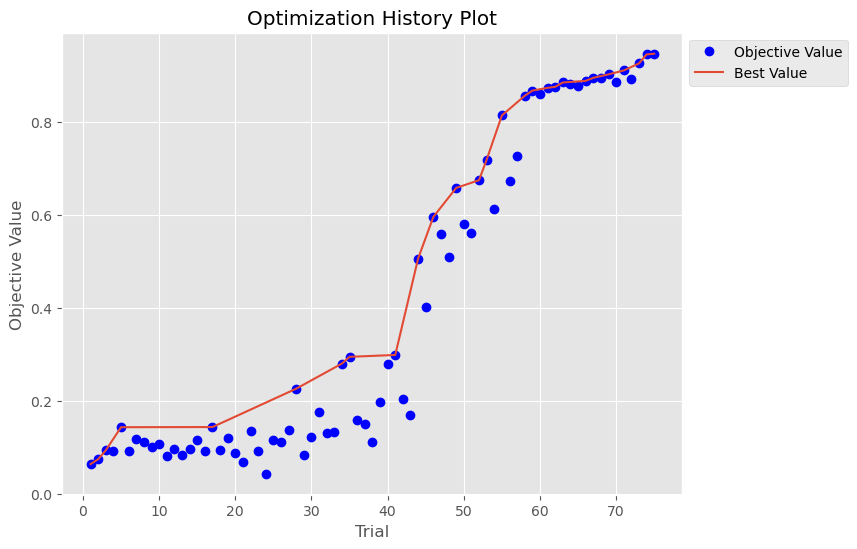

In [75]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(val_accs) + 1), val_accs, "bo", label="Objective Value")
plt.plot(best_acc_history["trial"], best_acc_history["acc"], label="Best Value")
plt.xlabel("Trial")
plt.ylabel("Objective Value")
plt.title("Optimization History Plot")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

Both methods are close in test accuracy, but Bayesian optimization achieves better results faster and I would assume the difference is even larger with bigger search space. Grid search is just computationally so expensive and grows exponentially with the number of parameter values to test. If the search space is small then grid search would be suitable.

# 2. Transfer learning

In [9]:
import random

seed = 42
torch.manual_seed(seed)
random.seed(seed)

Model - **DO NOT CHANGE THIS**

In [10]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Block 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.MaxPool1 = nn.MaxPool2d(kernel_size=2)

        # Block 2
        self.cnn2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.MaxPool2 = nn.MaxPool2d(kernel_size=2)

        # Block 3
        self.cnn3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.MaxPool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(576, 10)  # Fully connected layer

    def forward(self, x):
        out = self.MaxPool1(self.bn1(self.relu1(self.cnn1(x))))
        out = self.MaxPool2(self.bn2(self.relu2(self.cnn2(out))))
        out = self.MaxPool3(self.bn3(self.relu3(self.cnn3(out))))

        out = out.view(out.size(0), -1)
        out = self.fc1(out)

        return out

Load Fashion-MNIST data. 128 training samples, 10k test samples. **DO NOT CHANGE THIS**

In [11]:
transform = transforms.Compose([transforms.ToTensor()])
        
# Load full dataset
full_train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

batch_size = 128

# Slice small set of data
indices = random.sample(range(len(full_train_dataset)), batch_size)
train_dataset = Subset(full_train_dataset, indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Training set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))

Training set size: 128
Test set size: 10000


We recommend writing a general training function that implements all three alternative models.

Below **train_model()** function is a template that already has some functionality for storing the errors, doing evaluation over test dataset and printing results.

You should think about how to implement alternative ways of doing transfer learning.

Once you have this function, you can simply run the following cells to try out the alternative approaches.

In [12]:
# Training function
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs, freeze_layers):
    
    if freeze_layers:
        # freeze all layers
        for param in model.parameters():
            param.requires_grad = False
        # unfreeze the last layer 
        for param in model.fc1.parameters():
            param.requires_grad = True
        #num_ftrs = model.fc1.in_features
        #num_output = model.fc1.out_features
        #model.fc1 = nn.Linear(num_ftrs, num_output)  
        

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    # Training Loop
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_losses.append(total_loss / total)
        train_accs.append(100 * correct / total)

        # Evaluation
        model.eval()
        test_loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss_total += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        test_losses.append(test_loss_total / total)
        test_accs.append(100 * correct / total)

        print(f"Epoch {epoch+1:>2}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accs[-1]:.2f}% | "
              f"Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_accs[-1]:.2f}%")

    return train_losses, test_losses, train_accs, test_accs

## (2a) From Scratch

Create a new CNNModel and train from scratch.

In [13]:
model1 = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)
epochs = 50
freeze_layers = False
train_loss1, test_loss1, train_acc1, test_acc1 = train_model(model1, train_loader, test_loader, optimizer1,
                                                             criterion, epochs=epochs, freeze_layers=freeze_layers)

Epoch  1/50 | Train Loss: 2.5355 | Train Acc: 10.16% | Test Loss: 2.3114 | Test Acc: 18.27%
Epoch  2/50 | Train Loss: 2.2939 | Train Acc: 59.38% | Test Loss: 2.1896 | Test Acc: 16.89%
Epoch  3/50 | Train Loss: 1.7081 | Train Acc: 48.44% | Test Loss: 2.0351 | Test Acc: 29.10%
Epoch  4/50 | Train Loss: 1.0660 | Train Acc: 71.09% | Test Loss: 2.0655 | Test Acc: 31.40%
Epoch  5/50 | Train Loss: 0.6407 | Train Acc: 80.47% | Test Loss: 2.5470 | Test Acc: 19.26%
Epoch  6/50 | Train Loss: 0.5822 | Train Acc: 79.69% | Test Loss: 3.2496 | Test Acc: 10.33%
Epoch  7/50 | Train Loss: 0.3915 | Train Acc: 81.25% | Test Loss: 3.8419 | Test Acc: 10.02%
Epoch  8/50 | Train Loss: 0.2675 | Train Acc: 89.06% | Test Loss: 4.4610 | Test Acc: 10.00%
Epoch  9/50 | Train Loss: 0.2527 | Train Acc: 90.62% | Test Loss: 5.2563 | Test Acc: 10.02%
Epoch 10/50 | Train Loss: 0.2078 | Train Acc: 93.75% | Test Loss: 6.0982 | Test Acc: 10.13%
Epoch 11/50 | Train Loss: 0.1720 | Train Acc: 95.31% | Test Loss: 6.7728 | Test 

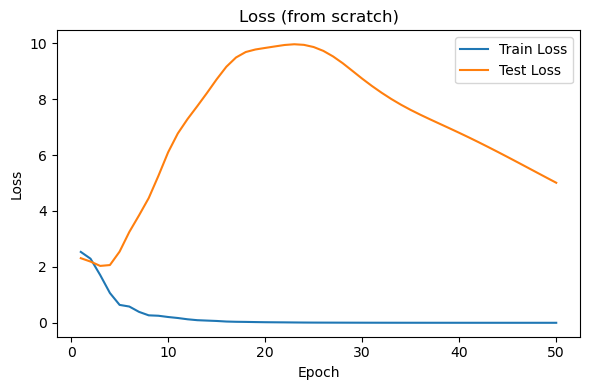

In [14]:
epoch_range = range(1, epochs + 1)
plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_loss1, label="Train Loss")
plt.plot(epoch_range, test_loss1, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (from scratch)")
plt.legend()
plt.tight_layout()
plt.show()

## (2b) Train only last layer of pre-trained model

Create a new CNNModel, load pre-trained weights, fix the weights of all other layers and only train the last layer. 

Remember to implement what happens when **freeze_layers = True** in the given **train_model()** function.

In [15]:
# Transfer Learning: Freeze all but last layer
model2 = CNNModel().to(device)
model2.load_state_dict(torch.load("pretrained_MNIST_model.pt"))
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)
epochs = 50
freeze_layers = True
train_loss2, test_loss2, train_acc2, test_acc2 = train_model(model2, train_loader, test_loader, optimizer2, 
                                                             criterion, epochs=epochs, freeze_layers=freeze_layers)

Epoch  1/50 | Train Loss: 10.3249 | Train Acc: 13.28% | Test Loss: 4.6077 | Test Acc: 22.53%
Epoch  2/50 | Train Loss: 6.0540 | Train Acc: 25.78% | Test Loss: 3.3054 | Test Acc: 29.61%
Epoch  3/50 | Train Loss: 3.7254 | Train Acc: 39.06% | Test Loss: 2.6625 | Test Acc: 38.05%
Epoch  4/50 | Train Loss: 2.4371 | Train Acc: 48.44% | Test Loss: 2.3402 | Test Acc: 44.78%
Epoch  5/50 | Train Loss: 1.7668 | Train Acc: 56.25% | Test Loss: 2.0748 | Test Acc: 50.14%
Epoch  6/50 | Train Loss: 1.1403 | Train Acc: 64.06% | Test Loss: 1.8857 | Test Acc: 56.47%
Epoch  7/50 | Train Loss: 0.7263 | Train Acc: 80.47% | Test Loss: 1.8122 | Test Acc: 59.25%
Epoch  8/50 | Train Loss: 0.4949 | Train Acc: 85.16% | Test Loss: 1.8067 | Test Acc: 60.20%
Epoch  9/50 | Train Loss: 0.3610 | Train Acc: 89.06% | Test Loss: 1.8307 | Test Acc: 61.05%
Epoch 10/50 | Train Loss: 0.2688 | Train Acc: 91.41% | Test Loss: 1.8787 | Test Acc: 62.08%
Epoch 11/50 | Train Loss: 0.2134 | Train Acc: 93.75% | Test Loss: 1.9418 | Test

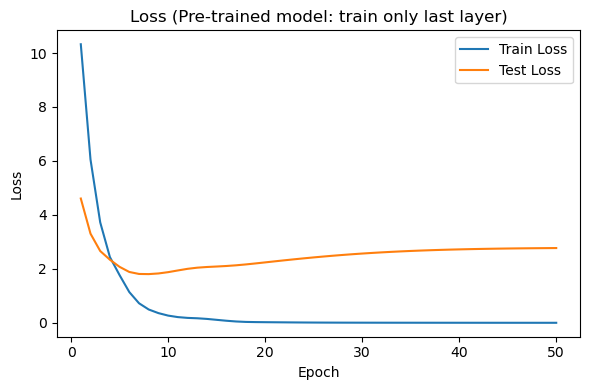

In [16]:
epoch_range = range(1, epochs + 1)
plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_loss2, label="Train Loss")
plt.plot(epoch_range, test_loss2, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Pre-trained model: train only last layer)")
plt.legend()
plt.tight_layout()
plt.show()

## (2c) Train all layers of pre-trained model

Create a new CNNModel, load pre-trained weights and fine-tune all weights.

In [17]:
model3 = CNNModel().to(device)
model3.load_state_dict(torch.load("pretrained_MNIST_model.pt"))
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.01)
epochs = 50
freeze_layers = False
train_loss3, test_loss3, train_acc3, test_acc3 = train_model(model3, train_loader, test_loader, optimizer3, 
                                                             criterion, epochs=epochs, freeze_layers=freeze_layers)

Epoch  1/50 | Train Loss: 10.3249 | Train Acc: 13.28% | Test Loss: 2.2428 | Test Acc: 29.69%
Epoch  2/50 | Train Loss: 2.5462 | Train Acc: 40.62% | Test Loss: 2.1012 | Test Acc: 42.66%
Epoch  3/50 | Train Loss: 1.1327 | Train Acc: 64.06% | Test Loss: 2.2611 | Test Acc: 45.04%
Epoch  4/50 | Train Loss: 0.7305 | Train Acc: 74.22% | Test Loss: 1.9319 | Test Acc: 57.72%
Epoch  5/50 | Train Loss: 0.3988 | Train Acc: 82.81% | Test Loss: 1.8156 | Test Acc: 61.70%
Epoch  6/50 | Train Loss: 0.3244 | Train Acc: 88.28% | Test Loss: 1.9035 | Test Acc: 58.75%
Epoch  7/50 | Train Loss: 0.2493 | Train Acc: 89.84% | Test Loss: 2.0141 | Test Acc: 59.25%
Epoch  8/50 | Train Loss: 0.2035 | Train Acc: 93.75% | Test Loss: 2.0337 | Test Acc: 62.38%
Epoch  9/50 | Train Loss: 0.1694 | Train Acc: 95.31% | Test Loss: 1.9722 | Test Acc: 63.41%
Epoch 10/50 | Train Loss: 0.1272 | Train Acc: 97.66% | Test Loss: 1.8748 | Test Acc: 64.88%
Epoch 11/50 | Train Loss: 0.0971 | Train Acc: 97.66% | Test Loss: 1.9184 | Test

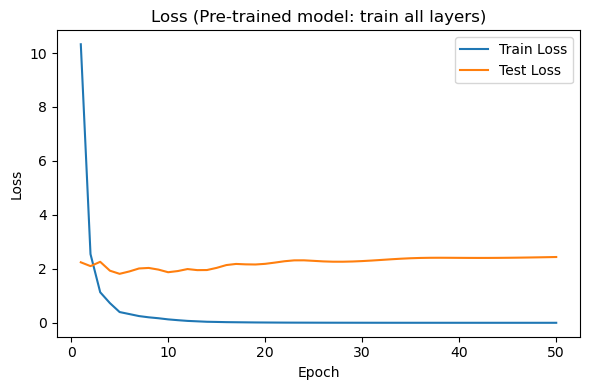

In [18]:
epoch_range = range(1, epochs + 1)
plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_loss3, label="Train Loss")
plt.plot(epoch_range, test_loss3, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Pre-trained model: train all layers)")
plt.legend()
plt.tight_layout()
plt.show()

## (2d) Plot and Report

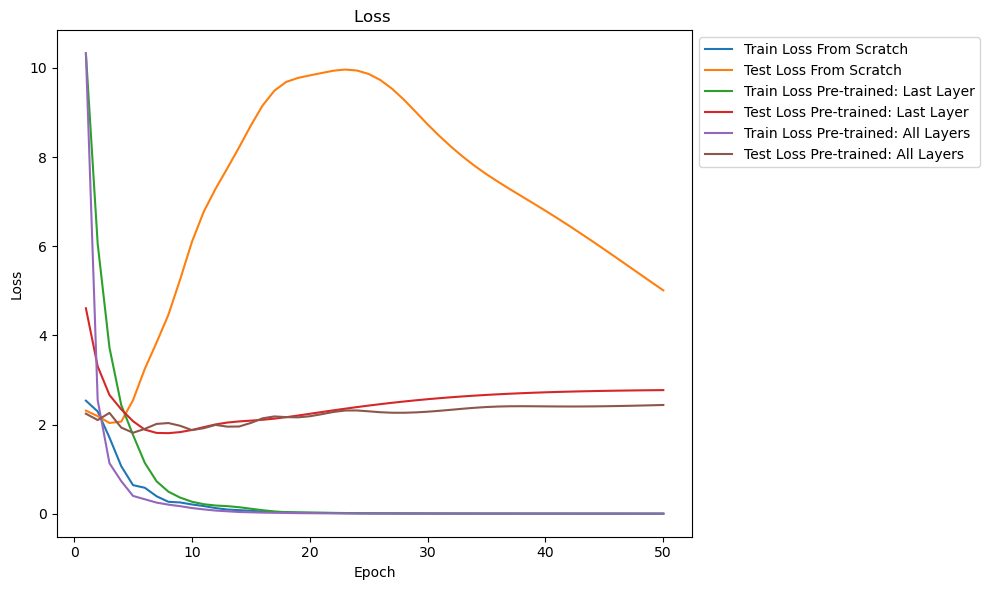

In [19]:
epoch_range = range(1, epochs + 1)
plt.figure(figsize=(10, 6))
for train, test, label in zip([train_loss1, train_loss2, train_loss3], 
                       [test_loss1, test_loss2, test_loss3],
                       ["From Scratch", "Pre-trained: Last Layer", "Pre-trained: All Layers"]): 
    plt.plot(epoch_range, train, label=f"Train Loss {label}")
    plt.plot(epoch_range, test, label=f"Test Loss {label}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss ")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

From scratch:
- Train Loss: 0.0007 | Train Acc: 100.00% | Test Loss: 5.0089 | Test Acc: 52.77%

Train only last layer:
- Train Loss: 0.0022 | Train Acc: 100.00% | Test Loss: 2.7723 | Test Acc: 66.30%

Train all layers:
- Train Loss: 0.0004 | Train Acc: 100.00% | Test Loss: 2.4388 | Test Acc: 66.63%

Both methods of transfer learning are superior to training from scratch, in terms of accuracy and computational time. Training from scratch could probably reach similar test accuracy on this data, but it just takes a lot longer. However, between the two transfer learning methods the difference is quite minimal in this case. Both converge to around the same test accuracy in roughly the same amount of epochs. Training only the last layer is perhaps slightly faster, giving it a slight edge.

# 3. Few-shot learning

Here **KShotCDataset()** function is given.

It is used to create a FashionMNIST dataloader for a given **K** and **C**.

**DO NOT CHANGE THIS**

In [20]:
from torch.utils.data import Dataset

# Set random seed for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)

class KShotCDataset(Dataset):
    def __init__(self, fashion_mnist_dataset, k_shot, c_way):
        self.fashion_mnist_dataset = fashion_mnist_dataset
        self.k_shot = k_shot
        self.c_way = c_way

        self.data_indices = []

        self.class_indices = {label: [] for label in range(self.c_way)}
        self.create_balanced_dataset()

    def create_balanced_dataset(self):
        for idx, (_, label) in enumerate(self.fashion_mnist_dataset):
            if label < self.c_way:
                self.class_indices[label].append(idx)

        for label in range(self.c_way):
            self.data_indices.extend(self.class_indices[label][:self.k_shot])

    def __len__(self):
        return len(self.data_indices)

    def __getitem__(self, index):
        fashion_mnist_index = self.data_indices[index]
        image, label = self.fashion_mnist_dataset[fashion_mnist_index]
        return image, label

# Load the Fashion MNIST training dataset
transform = transforms.Compose([transforms.ToTensor()])
fashionmnist_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

Below, you see an example of how to use **KShotCDataset().**

Implement the algorithm and follow the exercise sheet for details on what to analyse and report.

In [ ]:
K = 7  # Number of shots per class
C = 10  # Number of classes -- ordered labels are selected, e.g. C = 3 means labels=[0, 1, 2]
# Create the K-shot C-way dataset
k_shot_c_dataset = KShotCDataset(fashionmnist_dataset, K, C)

dataloader = DataLoader(k_shot_c_dataset, batch_size=K*C, shuffle=True)

model = CNNModel().to(device)
model.load_state_dict(torch.load("pretrained_MNIST_model.pt"))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 50
freeze_layers = True
train_loss, test_loss, train_acc, test_acc = train_model(model, train_loader, test_loader, optimizer, 
                                                             criterion, epochs=epochs, freeze_layers=freeze_layers)
for images, labels in dataloader:
    # Use the model for feature extraction ...
    # ...
    pass